# Defining a target with multiple stocks
## Goal
* Quantify how good our models have to be if we have one model for each stock in Dow Jones
* In this set up, each model is trying to predict if the asset is going to be higher in exactly 20 mins when compared to the next minute.

## Main takeouts



In [1]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [2]:
import pandas as pd
import random
import numpy as np
from datetime import datetime
from modeling.loadTimeSeries import loadTimeSeries
from modeling.loadTimeSeries import getListOfAvailableStocks
from modeling.loadTimeSeries import loadPriceTimeSeries
from modeling.marketSimulator import marketSimulator

In [11]:
def simulateStrategyMultipleTimes(precision, recall, availableStocks, numSimulations):
    outcome = []
    numMovements = []
    for i in range(numSimulations):
        strategy =strategySimulatorWithMultipleStocks(precision, recall, availableStocks)
        outcome.append(marketSimulator(strategy).values[-1])
        numMovements.append(countPositionChanges(strategy))
    return outcome, numMovements
    


def strategySimulatorWithMultipleStocks(precision, recall, availableStocks, startTime=datetime(2019,1,1), endTime=datetime(2020,1,1)):
    """
        This is cool enough to document
    """
    availableMarketMinutes = loadTimeSeries('GS').index
    strategyTimes = [t for t in availableMarketMinutes if t>=startTime and t<endTime]
    possibleMoves=[[] for _ in range(len(strategyTimes))]
    
    # we might want to keep the following always loaded !
    priceTimeSeries = loadPriceTimeSeries(startTime, endTime, availableStocks)
    bestPossiblePredictions = {stock: priceTimeSeries[stock].shift(-20)>priceTimeSeries[stock].shift(-1) for stock in priceTimeSeries}
    
    
    for stock in availableStocks:
        allPositives = bestPossiblePredictions[stock].value_counts()[True]
        predictedPositives = int(allPositives*recall/precision)
        truePositives = int(precision*predictedPositives)
        P = bestPossiblePredictions[stock].values
        TP = random.choices([i for i in range(len(P)) if P[i]==True], k=truePositives)
        FP = random.choices([i for i in range(len(P)) if P[i]==False], k=predictedPositives-truePositives)
        PP = TP+FP
        for p in PP:possibleMoves[p].append(stock)

    strategy = [None for _ in range(len(strategyTimes))]
    strategy[0] = random.choice(availableStocks)
    for i in range(1, len(strategy)):
        if len(possibleMoves[i])==0:
            strategy[i]=strategy[i-1]
        else:
            strategy[i] = random.choice(possibleMoves[i])
            
    
    counter = 1 # we force our positions to be held for at least 20 minutes
    for i in range(1, len(strategy)):
        if strategy[i]==strategy[i-1]:
            counter+=1
        else:
            if counter<20:
                strategy[i]=strategy[i-1]
                counter+=1
            else:
                counter=0
    
    
    strategy=pd.Series(strategy, index=strategyTimes)
    return strategy


def countPositionChanges(strategy):
    counter=0
    for i in range(1,len(strategy)):
        counter+=1 if strategy[i]!=strategy[i-1] else 0
    return counter


In [66]:
strat, movs =simulateStrategyMultipleTimes(precision=0.6, recall=0.02, availableStocks=['GS', 'MSFT', 'IBM'], numSimulations=100)

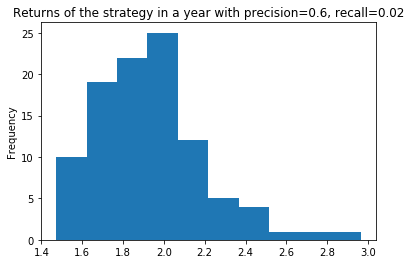

In [71]:
pd.Series(strat).plot.hist(title='Returns of the strategy in a year with precision=0.6, recall=0.02')

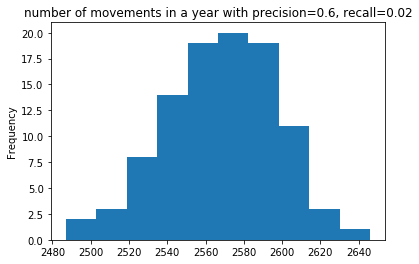

In [72]:
pd.Series(movs).plot.hist(title='number of movements in a year with precision=0.6, recall=0.02')

In [73]:
# Use the following in test_marketSimulator.py
def testCaseForModelSimulator(STOCK):
    S=loadTimeSeries(STOCK, datetime(2019,1,1), datetime(2020,1,1)).consolidated
    positionTS=pd.Series([STOCK]*len(S),index=S.index)
    win = marketSimulator(positionTS, initialAmount=1)
    return win.values[-1]


In [74]:
winGS = testCaseForModelSimulator('GS')
winIBM = testCaseForModelSimulator('IBM')
winMSFT = testCaseForModelSimulator('MSFT')

In [75]:
print(winGS, winIBM, winMSFT)

1.4279697238153024 1.2532322094050923 1.6108618098927572
